# Recurrent Neural Network - LSTM -  BTC

### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Loading the Data

In [2]:
df = pd.read_csv("yahoo_BTC-USD.csv")

## Preprocessing Data

In [3]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))
df.fillna(method='ffill',inplace=True)

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [4]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2018-09-10,0.051321
2018-09-11,0.051180
2018-09-12,0.051688
2018-09-13,0.054434
2018-09-14,0.054358


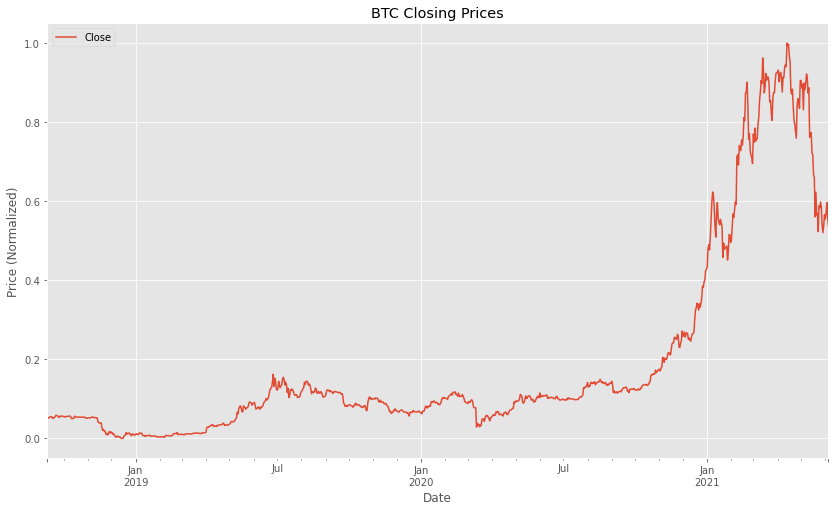

In [5]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price (Normalized)")
plt.show()

### Functions to prepare the data for LSTM

In [6]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

### Splitting the Data

In [9]:
# How many periods looking back to learn
n_per_in  = 30

# How many periods to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [10]:
# Instatiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1

In [11]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [12]:
res = model.fit(X, y, epochs=800, batch_size=32, validation_split=0.1)

Epoch 1/800
27/27 [==============================] - 23s 123ms/step - loss: 0.0289 - accuracy: 0.0631 - val_loss: 0.5646 - val_accuracy: 0.0619
Epoch 2/800
27/27 [==============================] - 1s 26ms/step - loss: 0.0270 - accuracy: 0.0708 - val_loss: 0.4919 - val_accuracy: 0.0619
Epoch 3/800
27/27 [==============================] - 1s 29ms/step - loss: 0.0142 - accuracy: 0.1005 - val_loss: 0.2733 - val_accuracy: 0.0619
Epoch 4/800
27/27 [==============================] - 1s 29ms/step - loss: 0.0075 - accuracy: 0.0883 - val_loss: 0.1214 - val_accuracy: 0.0619
Epoch 5/800
27/27 [==============================] - 1s 28ms/step - loss: 0.0030 - accuracy: 0.0868 - val_loss: 0.0642 - val_accuracy: 0.0619
Epoch 6/800
27/27 [==============================] - 1s 27ms/step - loss: 0.0024 - accuracy: 0.0876 - val_loss: 0.0573 - val_accuracy: 0.0619
Epoch 7/800
27/27 [==============================] - 1s 26ms/step - loss: 0.0019 - accuracy: 0.1662 - val_loss: 0.0509 - val_accuracy: 0.0825
Epoc

27/27 [==============================] - 1s 27ms/step - loss: 0.0013 - accuracy: 0.1430 - val_loss: 0.0252 - val_accuracy: 0.1649
Epoch 59/800
27/27 [==============================] - 1s 29ms/step - loss: 0.0013 - accuracy: 0.1285 - val_loss: 0.0231 - val_accuracy: 0.1649
Epoch 60/800
27/27 [==============================] - 1s 27ms/step - loss: 0.0011 - accuracy: 0.1290 - val_loss: 0.0270 - val_accuracy: 0.1649
Epoch 61/800
27/27 [==============================] - 1s 30ms/step - loss: 0.0011 - accuracy: 0.1494 - val_loss: 0.0280 - val_accuracy: 0.1649
Epoch 62/800
27/27 [==============================] - 1s 30ms/step - loss: 0.0012 - accuracy: 0.1559 - val_loss: 0.0244 - val_accuracy: 0.1649
Epoch 63/800
27/27 [==============================] - 1s 29ms/step - loss: 0.0010 - accuracy: 0.1543 - val_loss: 0.0250 - val_accuracy: 0.1649
Epoch 64/800
27/27 [==============================] - 1s 27ms/step - loss: 0.0012 - accuracy: 0.1429 - val_loss: 0.0243 - val_accuracy: 0.1649
Epoch 65/800

27/27 [==============================] - 1s 28ms/step - loss: 7.1656e-04 - accuracy: 0.1901 - val_loss: 0.0232 - val_accuracy: 0.1649
Epoch 115/800
27/27 [==============================] - 1s 27ms/step - loss: 6.5257e-04 - accuracy: 0.1387 - val_loss: 0.0208 - val_accuracy: 0.0825
Epoch 116/800
27/27 [==============================] - 1s 27ms/step - loss: 6.7863e-04 - accuracy: 0.1322 - val_loss: 0.0194 - val_accuracy: 0.0722
Epoch 117/800
27/27 [==============================] - 1s 28ms/step - loss: 7.5170e-04 - accuracy: 0.1523 - val_loss: 0.0242 - val_accuracy: 0.1753
Epoch 118/800
27/27 [==============================] - 1s 27ms/step - loss: 7.2393e-04 - accuracy: 0.1234 - val_loss: 0.0210 - val_accuracy: 0.1134
Epoch 119/800
27/27 [==============================] - 1s 29ms/step - loss: 7.7786e-04 - accuracy: 0.1496 - val_loss: 0.0210 - val_accuracy: 0.0825
Epoch 120/800
27/27 [==============================] - 1s 26ms/step - loss: 8.3126e-04 - accuracy: 0.1603 - val_loss: 0.0193 -

27/27 [==============================] - 1s 28ms/step - loss: 6.0249e-04 - accuracy: 0.1551 - val_loss: 0.0201 - val_accuracy: 0.0825
Epoch 170/800
27/27 [==============================] - 1s 28ms/step - loss: 6.4286e-04 - accuracy: 0.1430 - val_loss: 0.0212 - val_accuracy: 0.1134
Epoch 171/800
27/27 [==============================] - 1s 28ms/step - loss: 6.5735e-04 - accuracy: 0.1285 - val_loss: 0.0229 - val_accuracy: 0.1134
Epoch 172/800
27/27 [==============================] - 1s 31ms/step - loss: 6.1824e-04 - accuracy: 0.1640 - val_loss: 0.0189 - val_accuracy: 0.0825
Epoch 173/800
27/27 [==============================] - 1s 27ms/step - loss: 6.1675e-04 - accuracy: 0.1361 - val_loss: 0.0238 - val_accuracy: 0.1134
Epoch 174/800
27/27 [==============================] - 1s 32ms/step - loss: 6.7134e-04 - accuracy: 0.1785 - val_loss: 0.0242 - val_accuracy: 0.1134
Epoch 175/800
27/27 [==============================] - 1s 28ms/step - loss: 5.7697e-04 - accuracy: 0.1369 - val_loss: 0.0228 -

27/27 [==============================] - 1s 28ms/step - loss: 6.8238e-04 - accuracy: 0.1439 - val_loss: 0.0236 - val_accuracy: 0.1237
Epoch 225/800
27/27 [==============================] - 1s 28ms/step - loss: 6.2347e-04 - accuracy: 0.1657 - val_loss: 0.0212 - val_accuracy: 0.1443
Epoch 226/800
27/27 [==============================] - 1s 29ms/step - loss: 6.0715e-04 - accuracy: 0.1501 - val_loss: 0.0192 - val_accuracy: 0.0722
Epoch 227/800
27/27 [==============================] - 1s 34ms/step - loss: 5.6047e-04 - accuracy: 0.1652 - val_loss: 0.0197 - val_accuracy: 0.1237
Epoch 228/800
27/27 [==============================] - 1s 30ms/step - loss: 4.4360e-04 - accuracy: 0.1564 - val_loss: 0.0194 - val_accuracy: 0.0825
Epoch 229/800
27/27 [==============================] - 1s 30ms/step - loss: 5.5916e-04 - accuracy: 0.1612 - val_loss: 0.0239 - val_accuracy: 0.1649
Epoch 230/800
27/27 [==============================] - 1s 29ms/step - loss: 6.1021e-04 - accuracy: 0.1490 - val_loss: 0.0239 -

27/27 [==============================] - 1s 29ms/step - loss: 4.8246e-04 - accuracy: 0.1645 - val_loss: 0.0188 - val_accuracy: 0.0722
Epoch 280/800
27/27 [==============================] - 1s 29ms/step - loss: 6.1175e-04 - accuracy: 0.1332 - val_loss: 0.0277 - val_accuracy: 0.1649
Epoch 281/800
27/27 [==============================] - 1s 27ms/step - loss: 4.7410e-04 - accuracy: 0.1769 - val_loss: 0.0187 - val_accuracy: 0.1649
Epoch 282/800
27/27 [==============================] - 1s 29ms/step - loss: 5.7899e-04 - accuracy: 0.1650 - val_loss: 0.0247 - val_accuracy: 0.1031
Epoch 283/800
27/27 [==============================] - 1s 26ms/step - loss: 5.9112e-04 - accuracy: 0.1646 - val_loss: 0.0203 - val_accuracy: 0.0722
Epoch 284/800
27/27 [==============================] - 1s 30ms/step - loss: 5.9122e-04 - accuracy: 0.1758 - val_loss: 0.0218 - val_accuracy: 0.0825
Epoch 285/800
27/27 [==============================] - 1s 28ms/step - loss: 4.0956e-04 - accuracy: 0.1302 - val_loss: 0.0202 -

27/27 [==============================] - 1s 27ms/step - loss: 4.1386e-04 - accuracy: 0.1620 - val_loss: 0.0258 - val_accuracy: 0.1649
Epoch 335/800
27/27 [==============================] - 1s 27ms/step - loss: 3.6897e-04 - accuracy: 0.1377 - val_loss: 0.0188 - val_accuracy: 0.0825
Epoch 336/800
27/27 [==============================] - 1s 28ms/step - loss: 4.1703e-04 - accuracy: 0.1526 - val_loss: 0.0226 - val_accuracy: 0.1649
Epoch 337/800
27/27 [==============================] - 1s 27ms/step - loss: 4.0527e-04 - accuracy: 0.1435 - val_loss: 0.0211 - val_accuracy: 0.0825
Epoch 338/800
27/27 [==============================] - 1s 28ms/step - loss: 4.1056e-04 - accuracy: 0.1551 - val_loss: 0.0263 - val_accuracy: 0.1649
Epoch 339/800
27/27 [==============================] - 1s 26ms/step - loss: 4.1471e-04 - accuracy: 0.1574 - val_loss: 0.0206 - val_accuracy: 0.0928
Epoch 340/800
27/27 [==============================] - 1s 27ms/step - loss: 4.4964e-04 - accuracy: 0.1411 - val_loss: 0.0205 -

27/27 [==============================] - 1s 27ms/step - loss: 4.9522e-04 - accuracy: 0.1533 - val_loss: 0.0463 - val_accuracy: 0.1443
Epoch 390/800
27/27 [==============================] - 1s 27ms/step - loss: 3.7815e-04 - accuracy: 0.2089 - val_loss: 0.0531 - val_accuracy: 0.1649
Epoch 391/800
27/27 [==============================] - 1s 29ms/step - loss: 2.7570e-04 - accuracy: 0.1271 - val_loss: 0.0428 - val_accuracy: 0.1546
Epoch 392/800
27/27 [==============================] - 1s 28ms/step - loss: 5.0729e-04 - accuracy: 0.1753 - val_loss: 0.0335 - val_accuracy: 0.1031
Epoch 393/800
27/27 [==============================] - 1s 27ms/step - loss: 6.1196e-04 - accuracy: 0.1826 - val_loss: 0.0412 - val_accuracy: 0.1546
Epoch 394/800
27/27 [==============================] - 1s 27ms/step - loss: 3.8936e-04 - accuracy: 0.1623 - val_loss: 0.0489 - val_accuracy: 0.1649
Epoch 395/800
27/27 [==============================] - 1s 28ms/step - loss: 3.3395e-04 - accuracy: 0.1473 - val_loss: 0.0457 -

27/27 [==============================] - 1s 28ms/step - loss: 2.6329e-04 - accuracy: 0.1572 - val_loss: 0.0565 - val_accuracy: 0.1649
Epoch 445/800
27/27 [==============================] - 1s 28ms/step - loss: 2.6641e-04 - accuracy: 0.1460 - val_loss: 0.0551 - val_accuracy: 0.1649
Epoch 446/800
27/27 [==============================] - 1s 28ms/step - loss: 2.3800e-04 - accuracy: 0.1140 - val_loss: 0.0630 - val_accuracy: 0.1649
Epoch 447/800
27/27 [==============================] - 1s 28ms/step - loss: 2.6078e-04 - accuracy: 0.1664 - val_loss: 0.0446 - val_accuracy: 0.1443
Epoch 448/800
27/27 [==============================] - 1s 27ms/step - loss: 4.2001e-04 - accuracy: 0.1973 - val_loss: 0.0811 - val_accuracy: 0.1649
Epoch 449/800
27/27 [==============================] - 1s 28ms/step - loss: 0.0012 - accuracy: 0.1293 - val_loss: 0.0337 - val_accuracy: 0.1649
Epoch 450/800
27/27 [==============================] - 1s 28ms/step - loss: 8.9770e-04 - accuracy: 0.1713 - val_loss: 0.0279 - val

27/27 [==============================] - 1s 28ms/step - loss: 2.3569e-04 - accuracy: 0.1622 - val_loss: 0.0490 - val_accuracy: 0.1649
Epoch 500/800
27/27 [==============================] - 1s 28ms/step - loss: 2.6839e-04 - accuracy: 0.1682 - val_loss: 0.0429 - val_accuracy: 0.1649
Epoch 501/800
27/27 [==============================] - 1s 27ms/step - loss: 2.6228e-04 - accuracy: 0.1194 - val_loss: 0.0496 - val_accuracy: 0.1649
Epoch 502/800
27/27 [==============================] - 1s 28ms/step - loss: 2.4677e-04 - accuracy: 0.1651 - val_loss: 0.0512 - val_accuracy: 0.1649
Epoch 503/800
27/27 [==============================] - 1s 28ms/step - loss: 2.4145e-04 - accuracy: 0.1205 - val_loss: 0.0553 - val_accuracy: 0.1649
Epoch 504/800
27/27 [==============================] - 1s 28ms/step - loss: 2.6241e-04 - accuracy: 0.1181 - val_loss: 0.0540 - val_accuracy: 0.1649
Epoch 505/800
27/27 [==============================] - 1s 29ms/step - loss: 2.6435e-04 - accuracy: 0.1763 - val_loss: 0.0481 -

27/27 [==============================] - 1s 28ms/step - loss: 2.1774e-04 - accuracy: 0.1221 - val_loss: 0.0556 - val_accuracy: 0.1649
Epoch 555/800
27/27 [==============================] - 1s 27ms/step - loss: 2.5047e-04 - accuracy: 0.1340 - val_loss: 0.0547 - val_accuracy: 0.1649
Epoch 556/800
27/27 [==============================] - 1s 27ms/step - loss: 2.2698e-04 - accuracy: 0.1478 - val_loss: 0.0605 - val_accuracy: 0.1649
Epoch 557/800
27/27 [==============================] - 1s 27ms/step - loss: 2.4366e-04 - accuracy: 0.1284 - val_loss: 0.0557 - val_accuracy: 0.1649
Epoch 558/800
27/27 [==============================] - 1s 27ms/step - loss: 2.3164e-04 - accuracy: 0.1484 - val_loss: 0.0480 - val_accuracy: 0.1649
Epoch 559/800
27/27 [==============================] - 1s 28ms/step - loss: 2.3476e-04 - accuracy: 0.1464 - val_loss: 0.0514 - val_accuracy: 0.1649
Epoch 560/800
27/27 [==============================] - 1s 27ms/step - loss: 2.3592e-04 - accuracy: 0.1915 - val_loss: 0.0515 -

27/27 [==============================] - 1s 26ms/step - loss: 2.2463e-04 - accuracy: 0.1278 - val_loss: 0.0523 - val_accuracy: 0.1649
Epoch 610/800
27/27 [==============================] - 1s 27ms/step - loss: 2.2384e-04 - accuracy: 0.1618 - val_loss: 0.0571 - val_accuracy: 0.1649
Epoch 611/800
27/27 [==============================] - 1s 27ms/step - loss: 2.0659e-04 - accuracy: 0.1808 - val_loss: 0.0545 - val_accuracy: 0.1649
Epoch 612/800
27/27 [==============================] - 1s 28ms/step - loss: 2.1501e-04 - accuracy: 0.1433 - val_loss: 0.0607 - val_accuracy: 0.1649
Epoch 613/800
27/27 [==============================] - 1s 27ms/step - loss: 1.9142e-04 - accuracy: 0.1797 - val_loss: 0.0523 - val_accuracy: 0.1546
Epoch 614/800
27/27 [==============================] - 1s 27ms/step - loss: 2.0432e-04 - accuracy: 0.1759 - val_loss: 0.0562 - val_accuracy: 0.1649
Epoch 615/800
27/27 [==============================] - 1s 28ms/step - loss: 1.9115e-04 - accuracy: 0.1639 - val_loss: 0.0599 -

27/27 [==============================] - 1s 28ms/step - loss: 1.9359e-04 - accuracy: 0.1401 - val_loss: 0.0536 - val_accuracy: 0.1649
Epoch 664/800
27/27 [==============================] - 1s 31ms/step - loss: 6.3669e-04 - accuracy: 0.1636 - val_loss: 0.0525 - val_accuracy: 0.1649
Epoch 665/800
27/27 [==============================] - 1s 29ms/step - loss: 8.2200e-04 - accuracy: 0.1877 - val_loss: 0.0360 - val_accuracy: 0.1649
Epoch 666/800
27/27 [==============================] - 1s 30ms/step - loss: 5.1512e-04 - accuracy: 0.1850 - val_loss: 0.0325 - val_accuracy: 0.1753
Epoch 667/800
27/27 [==============================] - 1s 27ms/step - loss: 2.8041e-04 - accuracy: 0.1675 - val_loss: 0.0348 - val_accuracy: 0.1649
Epoch 668/800
27/27 [==============================] - 1s 27ms/step - loss: 2.6678e-04 - accuracy: 0.1782 - val_loss: 0.0449 - val_accuracy: 0.1649
Epoch 669/800
27/27 [==============================] - 1s 27ms/step - loss: 2.4576e-04 - accuracy: 0.1506 - val_loss: 0.0422 -

27/27 [==============================] - 1s 27ms/step - loss: 1.8081e-04 - accuracy: 0.1354 - val_loss: 0.0504 - val_accuracy: 0.1546
Epoch 719/800
27/27 [==============================] - 1s 27ms/step - loss: 1.8161e-04 - accuracy: 0.1980 - val_loss: 0.0557 - val_accuracy: 0.1649
Epoch 720/800
27/27 [==============================] - 1s 27ms/step - loss: 1.8634e-04 - accuracy: 0.1988 - val_loss: 0.0509 - val_accuracy: 0.1649
Epoch 721/800
27/27 [==============================] - 1s 30ms/step - loss: 1.9349e-04 - accuracy: 0.1775 - val_loss: 0.0512 - val_accuracy: 0.1649
Epoch 722/800
27/27 [==============================] - 1s 28ms/step - loss: 1.8881e-04 - accuracy: 0.1450 - val_loss: 0.0524 - val_accuracy: 0.1649
Epoch 723/800
27/27 [==============================] - 1s 27ms/step - loss: 1.9032e-04 - accuracy: 0.1542 - val_loss: 0.0484 - val_accuracy: 0.1649
Epoch 724/800
27/27 [==============================] - 1s 27ms/step - loss: 2.0246e-04 - accuracy: 0.1948 - val_loss: 0.0504 -

27/27 [==============================] - 1s 27ms/step - loss: 2.6192e-04 - accuracy: 0.1502 - val_loss: 0.0344 - val_accuracy: 0.1134
Epoch 774/800
27/27 [==============================] - 1s 27ms/step - loss: 2.0597e-04 - accuracy: 0.1382 - val_loss: 0.0309 - val_accuracy: 0.1649
Epoch 775/800
27/27 [==============================] - 1s 27ms/step - loss: 3.1045e-04 - accuracy: 0.1656 - val_loss: 0.0380 - val_accuracy: 0.1649
Epoch 776/800
27/27 [==============================] - 1s 27ms/step - loss: 2.5075e-04 - accuracy: 0.1916 - val_loss: 0.0539 - val_accuracy: 0.1649
Epoch 777/800
27/27 [==============================] - 1s 27ms/step - loss: 2.4034e-04 - accuracy: 0.2047 - val_loss: 0.0457 - val_accuracy: 0.1753
Epoch 778/800
27/27 [==============================] - 1s 27ms/step - loss: 2.1000e-04 - accuracy: 0.1980 - val_loss: 0.0447 - val_accuracy: 0.1546
Epoch 779/800
27/27 [==============================] - 1s 27ms/step - loss: 1.8316e-04 - accuracy: 0.1875 - val_loss: 0.0457 -

### Plotting the Accuracy and Loss

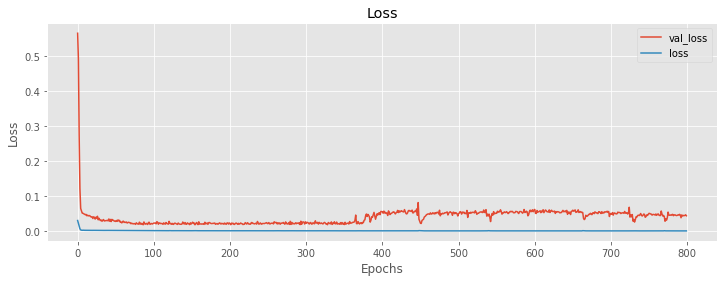

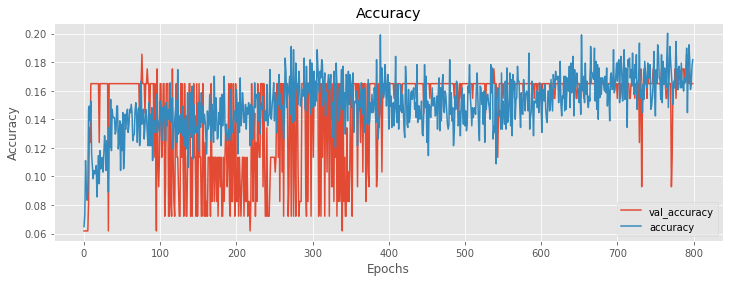

In [13]:
visualize_training_results(res)

## Visualizing the Predictions

### Validating the Model 
Plotting the difference between the Actual closing prices and the Predicted prices

Predicted Prices:
 [[38402.35854727139], [38711.82082840513], [40336.669330711884], [41529.77432387211], [42291.1681374605], [43207.99176964663], [44941.24492807306], [46563.17658430754], [48098.120131568794], [48903.65099896269]]

Actual Prices:
 [[38436.96875], [35697.605469], [34616.066406], [35678.128906], [37332.855469], [36684.925781], [37575.179688], [39208.765625], [36894.40625], [35746.101563]]


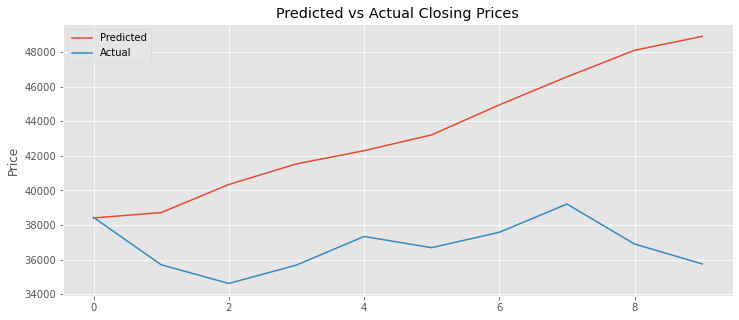

In [14]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

### Predicting/Forecasting the future prices

                   Close
2021-06-05  38299.740885
2021-06-06  38596.494051
2021-06-07  40235.804650
2021-06-08  41428.489359
2021-06-09  42202.419863
2021-06-10  43115.572292
2021-06-11  44854.644774
2021-06-12  46485.775990
2021-06-13  48026.987883
2021-06-14  48832.590594


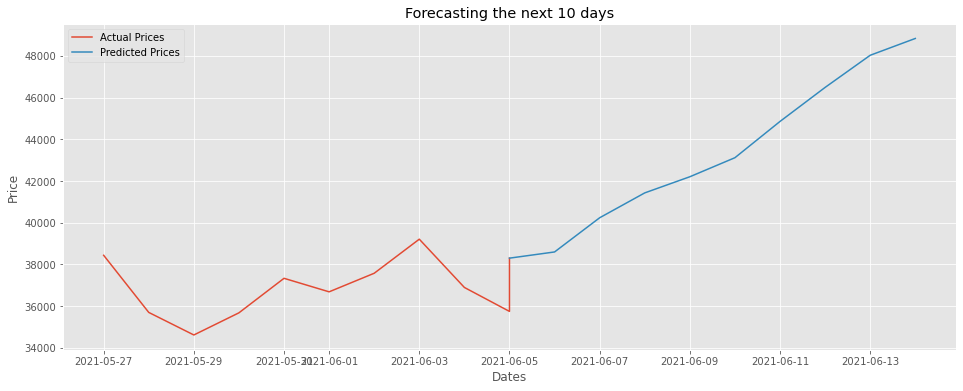

In [15]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()